In [1]:
#    All the necessary functions 
#    Run this cell

import cv2
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.applications.densenet import DenseNet121
from keras.models import Model
from keras.applications.densenet import preprocess_input
from keras.models import load_model
import numpy.linalg as npla
import tensorflow as tf

def create_triplet(size):
    sketches = os.listdir("../input/data-set/sketches/sketches")
    #sketches.remove('.DS.png')
    images = os.listdir("../input/data-set/ShoeV2_photo/ShoeV2_photo")
    #images.remove('.DS.png')
    anchor = []
    positive =[]
    negative = []
    used = []
    b_size = 0
    while(size>b_size):
        ske_ind = random.randint(0,6647)
        if(ske_ind not in used):
            s_name = sketches[ske_ind]
            p_name = s_name[:s_name.find("_")]+".png"
            p_ind = images.index(p_name)
            r = list(range(0,p_ind))+list(range(p_ind,2000))
            for i in range(1):
                anchor.append(s_name)
                positive.append(p_name)
                choosen = random.choice(r)
                negative.append(images[choosen])
                r.remove(choosen)
                b_size+=1
            
        used.append(ske_ind)

    return anchor,positive,negative

def show_triplet(anchor,positive,negative):
    ind = random.randint(0,len(anchor))
    print(anchor[ind])
    a = cv2.imread(os.path.join("../input/data-set/sketches/sketches",anchor[ind]))
    p = cv2.imread(os.path.join("../input/data-set/ShoeV2_photo/ShoeV2_photo",positive[ind]))
    n = cv2.imread(os.path.join("../input/data-set/ShoeV2_photo/ShoeV2_photo",negative[ind]))
    plt.subplot(131)
    plt.imshow(a)
    plt.subplot(132)
    plt.imshow(p)
    plt.subplot(133)
    plt.imshow(n)
    plt.show()

def get_mats(anchor,positive,negative):
    an = []
    po = []
    ne = []
    for i in range(len(anchor)):
        a = cv2.imread(os.path.join("../input/data-set/sketches/sketches",anchor[i]))
        a = cv2.resize(a,(224,224))
        p = cv2.imread(os.path.join("../input/data-set/ShoeV2_photo/ShoeV2_photo",positive[i]))
        p = cv2.resize(p,(224,224))
        n = cv2.imread(os.path.join("../input/data-set/ShoeV2_photo/ShoeV2_photo",negative[i]))
        n = cv2.resize(n,(224,224))
        an.append(a)
        po.append(p)
        ne.append(n)
        print(len(an))
    return an,po,ne


def show_img(img):
    a = cv2.imread(os.path.join("../input/data-set/ShoeV2_photo/ShoeV2_photo",img))
    plt.imshow(a)
    plt.show()
    
def show_sketch(sketch):
    a = cv2.imread(os.path.join("../input/data-set/sketches/sketches",sketch))
    plt.imshow(a)
    plt.show()

def custm_loss(y_true,y_pred):
    l = 50176
    a_e = y_pred[:,:l]
    p_e = y_pred[:,l:2*l]
    n_e = y_pred[:,2*l:]
    
    
    dp = tf.math.subtract(a_e,p_e)
    dn = tf.math.subtract(a_e,n_e)
    dp = tf.norm(tf.cast(dp,tf.float32))
    dn = tf.norm(tf.cast(dn,tf.float32))
    

    loss = tf.maximum(0.0,dp-dn+2)
    return loss

def get_photos_mat():
    mat = []
    name = os.listdir("../input/data-set/ShoeV2_photo/ShoeV2_photo")
    for img_name in name:
        img = cv2.imread(os.path.join("../input/data-set/ShoeV2_photo/ShoeV2_photo",img_name))
        img = cv2.resize(img,(224,224))
        mat.append(preprocess_input(img))
    return np.array(mat),name

def get_rank(s_name,matches):
    i_name = s_name[:s_name.find('_')]+'.png'
    print(i_name)
    ind = 0
    for i in range(len(matches)):
        if(matches[i][1]==i_name):
            ind = i
            break
    return ind

def give_loss_list(f_vec,name):
    l = 50176
    loss_name = []
    for i in range(len(f_vec)):
        a_e = f_vec[i][:l]
        p_e = f_vec[i][l:2*l]
        g = npla.norm(np.subtract(a_e,p_e))
        loss_name.append([g,name[i]])
    loss_name.sort(key = lambda x:x[0])
    return loss_name

Using TensorFlow backend.


In [ ]:
#      Training the model
#      Do not run this cell since the model is already trained

model = DenseNet121(weights = 'imagenet',include_top = 0,input_shape = (224,224,3))

a_in = keras.layers.Input((224,224,3))
p_in = keras.layers.Input((224,224,3))
n_in = keras.layers.Input((224,224,3))

a_feat = keras.layers.Flatten()(model(a_in))
p_feat = keras.layers.Flatten()(model(p_in))
n_feat = keras.layers.Flatten()(model(n_in))

out = keras.layers.concatenate([a_feat,p_feat,n_feat],axis = 1)
net = Model(inputs = [a_in,p_in,n_in],outputs = out)

net.compile(optimizer='adam',loss=custm_loss)

a,p,n = create_triplet(3000)
an,po,ne = get_mats(a,p,n)
an = np.array(an)
po = np.array(po)
ne = np.array(ne)
y = np.zeros((3000,150528))

an = preprocess_input(an)
po = preprocess_input(po)
ne = preprocess_input(ne)

net.fit([an,po,ne],y,verbose = 1,batch_size =10)
net.save('final_model_4.h5')

In [2]:
#     Loading the trained model
#     Run this cell

from keras.models import load_model
net = load_model('../input/network-4/final_model_4.h5', custom_objects={'custm_loss': custm_loss})

x_test,name = get_photos_mat()
neg = np.zeros((2000,224,224,3))

In [3]:
#     Run this cell


# Change the sketch name here

sketch_name = '2389700079_2.png'
sketch = cv2.imread(os.path.join("../input/data-set/sketches/sketches",sketch_name))
sketch = cv2.resize(sketch,(224,224))
sketch = preprocess_input(sketch)
an = np.zeros((2000,224,224,3))
for i in range(2000):
    an[i] = sketch

In [4]:
f_vec = net.predict([an,x_test,neg],verbose = 1)

2000/2000 [==============================] - 44s 22ms/step


In [5]:
matches = give_loss_list(f_vec,name)
ind = get_rank(sketch_name,matches)

2389700079.png


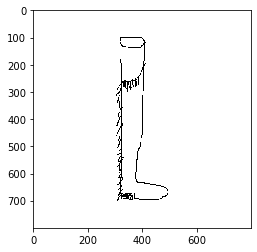

In [6]:
show_sketch(sketch_name)

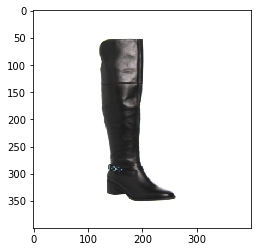

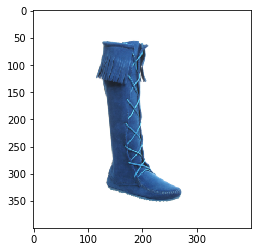

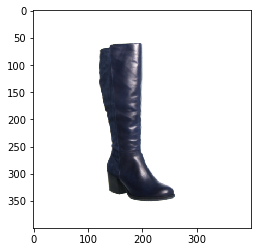

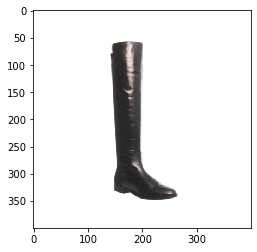

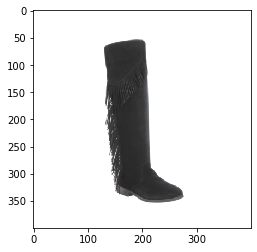

In [7]:
show_img(matches[0][1])
show_img(matches[1][1])
show_img(matches[2][1])
show_img(matches[3][1])
show_img(matches[ind][1])